## Assignment 5:1D CNN,  RNNs  and 2D CNN  with Applications 
### Adithya Jayan 181EC102 | Anvith M 181EC105

##### Import required libraries

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import glob 
import tqdm.notebook as tqdm
from tqdm.keras import TqdmCallback

In [2]:
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D,MaxPool2D,Flatten,Dense
from keras.models import Sequential
from keras.layers import Conv2DTranspose
from keras.backend import clear_session
from keras.layers import add 
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Concatenate
import tensorflow as tf

#### Q.1. Implement CNN(VGG16) model using Keras/Tensorflow library for Steel Defect Detection from dataset (https://www.kaggle.com/c/severstal-steel-defect-detection/data). For implementation, split dataset into training dataset (80%) and testing dataset (20%) ). Use a Adam gradient descent algorithm to learn model with parameters for α = 0.01 and random parameters of the CNN model for Binary cross entropy loss function. For better training performance, you can use batch-normalization and dropout if necessary.
- (i)Plot a comparative loss curve for at least 50 epochs 
- (ii) Print confusion matrix, calculate classification metrics such as precision, recall, F1-score, IoU and accuracy on test dataset and ROC curve. 

##### Reading Dataset 

In [3]:
Data = pd.read_csv("Data/severstal-steel-defect-detection/train.csv")
Data

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
...,...,...,...
7090,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...
7091,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...
7092,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...
7093,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...


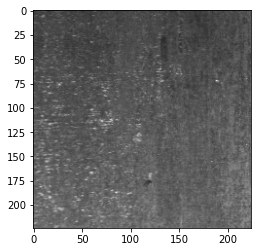

In [4]:
#Read inputs
files_to_read = 20 #Max=7095

X = []
list_of_files = Data["ImageId"]

# list_of_files = glob.glob("Data/severstal-steel-defect-detection/train_images/*") - Most files here are unlabelled hence read only labelled ones

for i in tqdm.tqdm(list_of_files[:files_to_read]):
    temp = cv2.imread("Data/severstal-steel-defect-detection/train_images/"+i)
    X.append(temp[:224,:224]/255)

X = np.array(X)
plt.imshow(X[0])

#Read truth labels
Y = pd.get_dummies(Data["ClassId"]).values[:files_to_read]
Y = np.array(Y)

In [5]:
# ## In case you want to read dataset only partially, stop the previous cell midway and run this
# ## Comment this cell later for full run!!!!!!!!!!!

# plt.imshow(X[0])
# X = np.array(X)


# #Read truth labels
# Y = Data["ClassId"]
# Y = Y[0:len(X)]
# Y = pd.get_dummies(Y).values

# Y = np.array(Y)

In [6]:
#Split data to test and train sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size =0.2, shuffle = True)

In [7]:
print(np.shape(X_train),np.shape(X_test),np.shape(Y_train),np.shape(Y_test))

(16, 224, 224, 3) (4, 224, 224, 3) (16, 4) (4, 4)


##### Defining required functions and model

In [8]:
clear_session()

In [9]:
model = Sequential()

model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu")) #Changed Input Dimension Inputs - 1600x256x64
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu")) #1600x256x64
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2))) #800x128x64

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")) #800x128x128
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")) #800x128x128
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2))) #400x64x128

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")) #400x64x256
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")) #400x64x256
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")) #400x64x256
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2))) #200x32x256

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")) #200x32x512
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")) #200x32x512
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")) #200x32x512
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2))) #100x16x512

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")) #100x16x512
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")) #100x16x512
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")) #100x16x512
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2))) #50x8x512

model.add(Flatten()) #1x1x204800

model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4, activation="softmax"))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       2

##### Running code 

In [11]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [12]:
history = model.fit(X_train, Y_train, epochs=5, batch_size=1, verbose=0,callbacks=[TqdmCallback(verbose=1)])

##### Evaluating performance

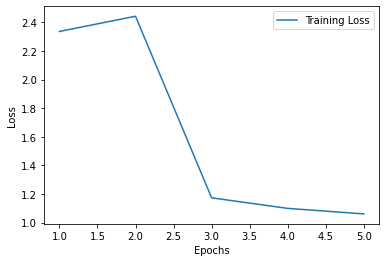

In [13]:
#Plotting loss curve

loss_values = history.history['loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [14]:
#Plotting confusion matrix

prediction = model.predict(X_test)

y_actu = pd.Series(np.argmax(Y_test,axis=1)+1, name='Actual')
y_pred = pd.Series(np.argmax(prediction,axis=1)+1, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
df_confusion

Predicted,3
Actual,
1,1
2,2
3,1


#### Q.2. Implement CNN(VGG16) model for Predicting Invasive Ductal Carcinoma (IDC) in Breast Cancer Histology Images (https://www.kaggle.com/paultimothymooney/breast-histopathology-images). For implementation, split dataset into training dataset (80%) and testing dataset (20%) ). Use an Adam gradient descent algorithm to learn model with parameters for α = 0.01 and random parameters of the parameters of the CNN model for Focal loss function. For better training performance, you can use batch-normalization and dropout if necessary. 
- (i) Plot a comparative loss curve for at least 50 epochs. 
- (ii)Print confusion matrix, calculate classification metrics such as precision, recall, F1-score, IoU and accuracy on test dataset and ROC curve. 

##### Reading Dataset 

In [15]:
X = []
Y = []
folders = 10 #How many folders of data to read , -1 for all

List_of_folders = glob.glob("Data/breast-histopathology-images/*")
for i in tqdm.tqdm(List_of_folders[:10]):
    for j in glob.glob(i+"/0/*.png"):
        X.append(cv2.imread(j)/255)
        Y.append(0)
    for j in glob.glob(i+"/1/*.png"):
        X.append(cv2.imread(j)/255)
        Y.append(1)
        
X = np.array(X)
Y = np.array(Y)

In [16]:
print(len(X),len(Y))
X =  X[:len(Y)]

8509 8509


In [17]:
#Split data to test and train sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size =0.2, shuffle = True)

In [18]:
print(np.shape(X_train),np.shape(X_test),np.shape(Y_train),np.shape(Y_test))

(6807, 50, 50, 3) (1702, 50, 50, 3) (6807,) (1702,)


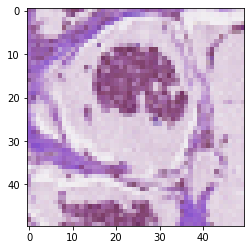

In [19]:
plt.imshow(X_train[0])

##### Defining required functions

In [20]:
def focal_loss(y_true,y_pred):
    gamma = 0.2
    alpha = 1.0
    epsilon = 1.e-9
    
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
#     y_true = tf.convert_to_tensor(y_true, tf.float32)
#     y_pred = tf.convert_to_tensor(y_pred, tf.float32)
    
    model_out = tf.add(y_pred, epsilon)
    ce = tf.multiply(y_true, -tf.math.log(model_out))
    weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
    fl = tf.multiply(alpha, tf.multiply(weight, ce))
    reduced_fl = tf.reduce_max(fl, axis=1)
    
    return tf.reduce_mean(reduced_fl)

In [21]:
clear_session()

In [22]:
model = Sequential()

model.add(Conv2D(input_shape=(50,50,3),filters=64,kernel_size=(3,3),padding="same", activation="relu")) #Changed Input Dimension Inputs - 1600x256x64
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu")) #1600x256x64
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2))) #800x128x64

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")) #800x128x128
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")) #800x128x128
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2))) #400x64x128

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")) #400x64x256
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")) #400x64x256
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")) #400x64x256
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2))) #200x32x256

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")) #200x32x512
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")) #200x32x512
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")) #200x32x512
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2))) #100x16x512

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")) #100x16x512
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")) #100x16x512
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")) #100x16x512
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2))) #50x8x512

model.add(Flatten()) #1x1x204800

model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=1, activation="sigmoid"))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 256)       2

##### Running code 

In [24]:
model.compile(loss='mse', optimizer='adam')

In [25]:
model.fit(X_train, Y_train, epochs=1, batch_size=32, verbose=0,callbacks=[TqdmCallback(verbose=1)])

#### Q.3. Implement FCN8 model using Keras/Tensorflow library for Building footprint segmentation from aerial remote sensing images (https://github.com/menvuthy/building-footprint-dataset). For implementation, split dataset into training dataset (80%) and testing dataset (20%) ). Use a Adam gradient descent algorithm to learn model with parameters for α = 0.01 and random parameters of the CNN model for Dice Loss function. For better training performance, you can use batch-normalization and dropout if necessary. 
- (i) Plot a comparative loss curve for at least 50 epochs. 
- (ii) Print confusion matrix, calculate overall as well as classwise classification metrics such as bulding and Background accuracy, Segmentation Accuracy, Dice Coefficient, IoU) on test dataset. 

##### Reading Dataset 

In [26]:
X = []
Y = []

for i in tqdm.tqdm(glob.glob("Data/building-footprint-dataset/data/train/image/*")):
    X.append(cv2.imread(i)/255)    
    Y.append(cv2.imread(i.replace("image","mask").replace("tiff","tif"))/255)
    
X = np.array(X)
Y = np.array(Y)

In [27]:
print(len(X),len(Y))
X =  X[:len(Y)]

116 116


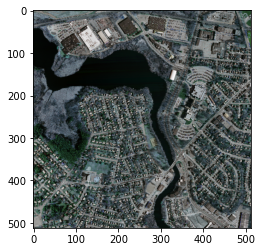

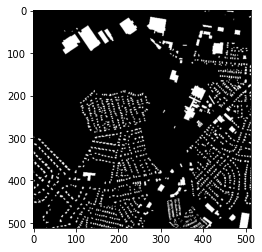

In [28]:
plt.imshow(X[0])
plt.figure()
plt.imshow(Y[0])

In [29]:
#Split data to test and train sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size =0.2, shuffle = True)

In [30]:
print(np.shape(X_train),np.shape(X_test),np.shape(Y_train),np.shape(Y_test))

(92, 512, 512, 3) (24, 512, 512, 3) (92, 512, 512, 3) (24, 512, 512, 3)


##### Defining required functions

In [31]:
clear_session()

In [32]:
inputs = tf.keras.Input(shape=(512,512,3))

x1 = Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu")(inputs)
x1 = Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu")(x1)
x1 = Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu")(x1)                   
x1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(x1)

x2 = Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu")(x1)
x2 = Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu")(x2)                   
x2 = MaxPool2D(pool_size=(2,2),strides=(2,2))(x2)

x3 = Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu")(x2)
x3 = Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu")(x3)
x3 = Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu")(x3)                   
x3 = MaxPool2D(pool_size=(2,2),strides=(2,2))(x3)

x4 = Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu")(x3)
x4 = Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu")(x4)
x4 = Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu")(x4)                   
x4 = MaxPool2D(pool_size=(2,2),strides=(2,2))(x4)

x5 = Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu")(x4)
x5 = Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu")(x5)
x5 = Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu")(x5)                   
x5 = MaxPool2D(pool_size=(2,2),strides=(2,2))(x5)

upscaled_L1 = Conv2DTranspose(3, kernel_size=(4, 4),strides=(2, 2),padding="same")(x5)
upscaled_L2 = Conv2D(3, kernel_size=(1, 1), activation='relu', padding='same')(x4)
Added1 = add([upscaled_L1, upscaled_L2])

upscaled_L3 = Conv2DTranspose(3, kernel_size=(4, 4),strides=(2, 2),padding="same")(Added1)
upscaled_L4 = Conv2D(3, kernel_size=(1, 1), activation='relu', padding='same')(x3)
Added2 = add([upscaled_L3, upscaled_L4])

outputs = Conv2DTranspose(3, kernel_size=(8, 8),strides=(8, 8),padding="same")(Added2)
outputs = tf.keras.layers.Activation('softmax')(outputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 64) 36928       conv2d_1[0][0]                   
______________________________________________________________________________________________

##### Running code 

In [34]:
model.compile(loss='mse', optimizer='adam')

In [ ]:
## Too heavy for laptop to run
model.fit(X_train, Y_train, epochs=2, batch_size=32, verbose=0,callbacks=[TqdmCallback(verbose=1)])

#### Q.4.Implement U-Net model for the multi-class schematic segmentation of aerial images (Dataset: https://www.kaggle.com/humansintheloop/semantic-segmentation-of-aerial-imagery). Use an Adam gradient descent algorithm to learn model with parameters for α = 0.01 and random parameters of the model for Focal loss function. For better training performance, you can use batch-normalization and dropout if necessary. 
- (i)Plot a comparative loss curve for at least 50 epochs. 
- (ii)Print confusion matrix, calculate overall as well as class-wise classification metrics such as precision, recall, F1-score, IoU, Accuracy on test datset. 

##### Reading Dataset 

In [35]:
#Each tile set has images of different shape

X = []
Y = []

#Resizes the images of different sizes to output_shape
output_shape = (500,500)

for i in tqdm.tqdm(glob.glob("Data/semantic-segmentation-of-aerial-imagery/Semantic_segmentation_dataset/Tile*/images/*")):
    X.append(cv2.resize(cv2.imread(i) , output_shape)/255)    
    Y.append(cv2.resize(cv2.imread(i.replace("images","masks").replace("jpg","png")), output_shape)/255)
#     print(X[-1].shape,Y[-1].shape)
    
X = np.array(X)
Y = np.array(Y)

In [36]:
#Split data to test and train sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size =0.2, shuffle = True)

In [37]:
print(np.shape(X_train),np.shape(X_test),np.shape(Y_train),np.shape(Y_test))

(57, 500, 500, 3) (15, 500, 500, 3) (57, 500, 500, 3) (15, 500, 500, 3)


##### Defining required functions

In [ ]:
clear_session()

In [ ]:
inputs = tf.keras.Input((500,500,3))


# s1, p1 = encoder_block_by_2(inputs, 64)   
x = Conv2D(64, 3, padding="same")(inputs)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(64, 3, padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
s1 = MaxPool2D((2, 2))(x)
#out = 250*250*64


# s2, p2 = encoder_block_by_2(p1, 128)
x = Conv2D(128, 3, padding="same")(s1)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(128, 3, padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
s2 = MaxPool2D((2, 2))(x)
#out = 125*125*128


# s3, p3 = encoder_block_by_3(p2, 256)
x = Conv2D(256, 3, padding="same")(s2)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(256, 3, padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
s3 = MaxPool2D((3, 3))(x)
#out = 250*250*256


# s4, p4 = encoder_block_by_5(p3, 512)
x = Conv2D(512, 3, padding="same")(s3)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(512, 3, padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
s4 = MaxPool2D((5, 5))(x)

# """ Bridge """

# b1 = conv_block(p4, 1024)
x = Conv2D(1024, 3, padding="same")(s4)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(1024, 3, padding="same")(x)
x = BatchNormalization()(x)
b1 = Activation("relu")(x)

# """ Decoder """

# d1 = decoder_block_by_5(b1, s4, 512)
x = Conv2DTranspose(512, (5, 5), strides=5, padding="same")(b1)
x = Concatenate()([x, s4])
x = Conv2D(512, 3, padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(512, 3, padding="same")(x)
x = BatchNormalization()(x)
d1 = Activation("relu")(x)

# d2 = decoder_block_by_3(d1, s3, 256)
x = Conv2DTranspose(num_filters, (3, 3), strides=3, padding="same")(d1)
x = Concatenate()([x, s3])
x = Conv2D(num_filters, 3, padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(num_filters, 3, padding="same")(x)
x = BatchNormalization()(x)
d2 = Activation("relu")(x)

# d3 = decoder_block_by_2(d2, s2, 128)
x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(d2)
x = Concatenate()([x, s2])
x = Conv2D(num_filters, 3, padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(num_filters, 3, padding="same")(x)
x = BatchNormalization()(x)
d3 = Activation("relu")(x)

# d4 = decoder_block_by_2(d3, s1, 64)
x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(d3)
x = Concatenate()([x, s1])
x = Conv2D(num_filters, 3, padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(num_filters, 3, padding="same")(x)
x = BatchNormalization()(x)
d4 = Activation("relu")(x)

# print(d1.shape, d2.shape, d3.shape, d4.shape)

# outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

# model = Model(inputs, outputs, name="U-Net")
model = Model(inputs, outputs, name="U-Net")

In [ ]:
model.summary()

#### Q.5.
- (a)Write python from scratch for 2D Depthwise Separbale convolution between input image(lena.jpg) and depthwise and pointwise filters are as follows and also compute number of multiplications and parameters required for 2D Depthwise Separbale convolutions depthwise filter array = np.array([[[1, 2, 1], [2, 4, 2], [1, 2, 1]], [[1, 2, 1], [2, 4, 2], [1, 2, 1]], [[1, 2, 1], [2, 4, 2], [1, 2, 1]]])/16 pointwise filter array = np.array([[1], [1], [1]])/512 
- (b) Write python from scratch for 2D Atrous/Dilated cnvolution between input image(lena.jpg) and filter which is given below with rate 3: filter= np.array([[1, 2, 1],[2, 4, 2], [1, 2, 1]])/16

##### (a)

In [38]:
filt = np.array([[[1, 2, 1], [2, 4, 2], [1, 2, 1]], [[1, 2, 1], [2, 4, 2], [1, 2, 1]], [[1, 2, 1], [2, 4, 2], [1, 2, 1]]])/16
point = np.array([[1], [1], [1]])/512

print("filt:\n",filt)
print("\n\npoint:\n",point)

filt:
 [[[0.0625 0.125  0.0625]
  [0.125  0.25   0.125 ]
  [0.0625 0.125  0.0625]]

 [[0.0625 0.125  0.0625]
  [0.125  0.25   0.125 ]
  [0.0625 0.125  0.0625]]

 [[0.0625 0.125  0.0625]
  [0.125  0.25   0.125 ]
  [0.0625 0.125  0.0625]]]


point:
 [[0.00195312]
 [0.00195312]
 [0.00195312]]


In [39]:
# Seperate kernal into 3 dimensions
f1 = np.reshape(np.array([[1,1,1]]) , (3,1,1))
f2 = np.reshape(np.array([[1,2,1]])/4 , (1,3,1))
f3 = np.reshape(np.array([[1,2,1]])/4 , (1,1,3))
print(f1.shape,f2.shape,f3.shape)


temp = np.matmul(f2,f1)
out = np.matmul(temp,f3)
print(out)


(3, 1, 1) (1, 3, 1) (1, 1, 3)
[[[0.0625 0.125  0.0625]
  [0.125  0.25   0.125 ]
  [0.0625 0.125  0.0625]]

 [[0.0625 0.125  0.0625]
  [0.125  0.25   0.125 ]
  [0.0625 0.125  0.0625]]

 [[0.0625 0.125  0.0625]
  [0.125  0.25   0.125 ]
  [0.0625 0.125  0.0625]]]


In [40]:
img = cv2.imread('Data/lena.tif')
img = cv2.resize(img,(100,100))
img.shape


(100, 100, 3)

##### Defining required functions

In [41]:
def convolve(Image,kernel,padding = (0,0),s = 1):
    
    #kernel = np.flipud(np.fliplr(kernel))
    p1,p2 = padding
    
    x,y = Image.shape

    x_k,y_k = kernel.shape

    out_x = (x-x_k+2*p1)//s+1
    out_y = (y-y_k+2*p2)//s+1
    
    out = np.zeros((out_x,out_y))
    
    Img_padded = np.zeros((x+2*p1,y+2*p2))
    Img_padded[p1:p1+x,p2:p2+y] = Image
    Image = Img_padded
    
    for i in range(out_x):
        i_img = i*s
        for j in range(out_y):
            j_img = j*s
            out[i,j] = np.sum(Image[i_img:i_img+x_k,j_img:j_img+y_k]*kernel)
            
#     print("Convolution:\n",out)
#     print("Multiplications performed: ",(out_x*out_y*x_k*y_k))

    
    return out

In [42]:
def Depthwise_Separbale_convolution(Img,f):
    kernel = f[0]
    kernel_depth = np.array([np.mean(i/f[0]) for i in f])
    
    layers = np.array([convolve(Img[:,:,i],kernel) for i in range(Img.shape[2])])
    output = np.sum([layers[i]*kernel_depth[i] for i in range(len(kernel_depth))] , axis = 0)
    print(output.shape)
    return(output)

##### Running code 

(98, 98)


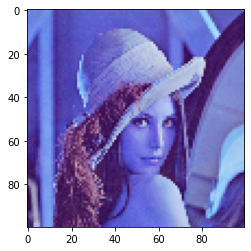

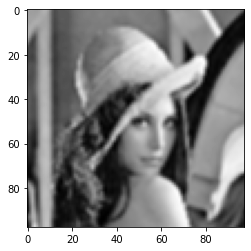

In [43]:
result = Depthwise_Separbale_convolution(img,filt)
plt.imshow(img)
plt.figure()
plt.imshow(result,cmap='gray')

##### (b)

In [49]:
img = cv2.imread('Data/lena.tif',0)
img = cv2.resize(img,(100,100))
img.shape

(100, 100)

In [50]:
#Function to dilate kernal
def update_kernal(kernal, rate = 1):
    update = np.zeros((rate * (kernal.shape[0] - 1) + 1,rate * (kernal.shape[1] - 1) + 1))
    for i in range(kernal.shape[0]):
        for j in range(kernal.shape[1]):
            update[i*rate,j*rate] = kernal[i, j] 
    return update

In [51]:
#Function for Convolution
def convolve(Image, kernel, padding = (0,0), s = 1):
    
    #kernel = np.flipud(np.fliplr(kernel))
    p1,p2 = padding
    
    x,y = Image.shape

    x_k,y_k = kernel.shape

    out_x = (x-x_k+2*p1)//s+1
    out_y = (y-y_k+2*p2)//s+1
    
    out = np.zeros((out_x,out_y))
    
    Img_padded = np.zeros((x+2*p1,y+2*p2))
    Img_padded[p1:p1+x,p2:p2+y] = Image
    Image = Img_padded
    
    for i in range(out_x):
        i_img = i*s
        for j in range(out_y):
            j_img = j*s
            out[i,j] = np.sum(Image[i_img:i_img+x_k,j_img:j_img+y_k]*kernel)
            
#    print("Convolution:\n",out)
#    print("\nTotal number of multiplications is: ",(out_x*out_y*x_k*y_k))
    
    return out

In [52]:
#Dilated Convolution Function
def dilated_convolve(Image, Filter, rate = 1):
    update_filter = update_kernal(Filter, rate)
    output = convolve(Image, update_filter)

    return output

In [53]:
# Defining Filter 
filter = np.array([[1,2,1],[2,4,2],[1,2,1]])/16
rate = 2

In [54]:
output = dilated_convolve(img, filter, rate)

Text(0.5, 1.0, 'Output Image for rate 2')

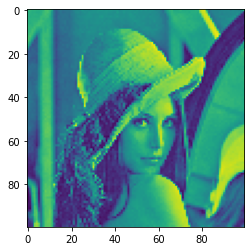

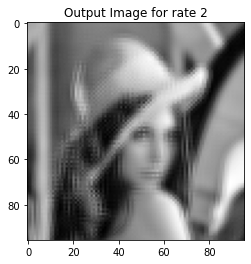

In [56]:
plt.imshow(img)
plt.figure()
plt.imshow(output,cmap='gray')
plt.title("Output Image for rate {}".format(rate))